In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import ParameterGrid
from prophet import Prophet

What is Prophet 

In [44]:
df = pd.read_csv(r"C:\Users\siddharth\Desktop\Python-Time-Series-Forecasting\Python - Time Series Forecasting\Modern Time Series Forecasting Techniques\Prophet\Daily Bike Sharing training.csv")


In [45]:
df = df.rename(columns={
    'cnt': 'y', 
    'dteday': "ds"
})

df['ds'] = pd.to_datetime(df['ds'], format = "%m/%d/%Y")

weather_sit = pd.get_dummies(df['weathersit'], drop_first=True) 
df = pd.concat([df, weather_sit], axis = 1) 


df = df.rename(columns={2: 'weather_sit_2',3:'weather_sit_3'})

df

,instant,ds,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,y,weather_sit_2,weather_sit_3
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,True,False
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,True,False
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,False,False
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,False,False
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,697,2012-11-27,4,1,11,0,2,1,2,0.291667,0.281558,0.786667,0.237562,123,3836,3959,True,False
697,698,2012-11-28,4,1,11,0,3,1,1,0.296667,0.289762,0.506250,0.210821,198,5062,5260,False,False
698,699,2012-11-29,4,1,11,0,4,1,1,0.280870,0.298422,0.555652,0.115522,243,5080,5323,False,False
699,700,2012-11-30,4,1,11,0,5,1,1,0.298333,0.323867,0.649583,0.058471,362,5306,5668,False,False


In [46]:
df = df.drop(
    columns=["instant", "season", "yr", "mnth", "weekday", "casual", "registered"]
)

In [47]:
# Replace 29/30 of October 2012 with the values of 28th
# 28th because in EDA weekly seasonality is not obvious 
# This comes from eda 

to_replace = df.loc[df.ds == '2012-10-28'].y.values[0]
df.loc[df.ds == '2012-10-29', 'y'] = to_replace
df.loc[df.ds == '2012-10-30', 'y'] = to_replace

Exploratory Data Analysis 

In [48]:
## EDA 

df_temp = df.copy() 

df_temp.set_index('ds', inplace=True)
df_temp.index.freq = "D" 



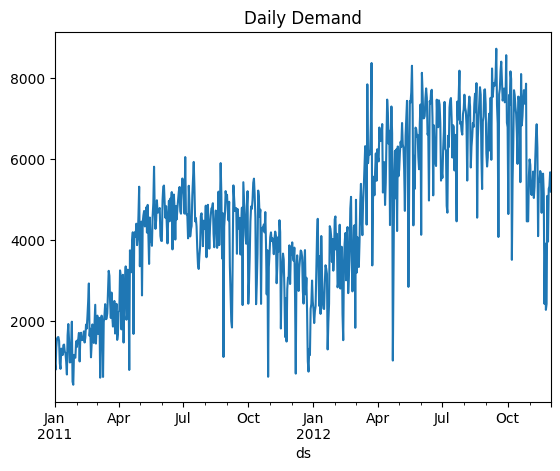

In [49]:
df_temp['y'].plot(title='Daily Demand');

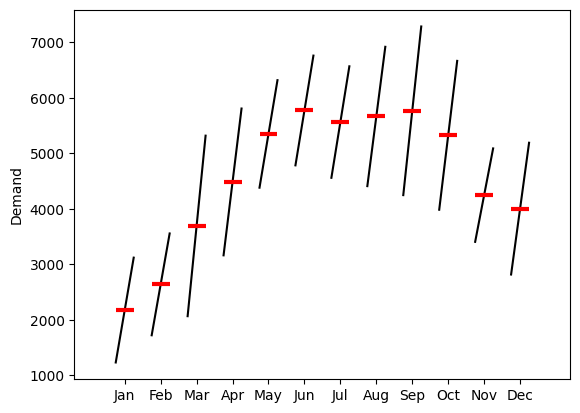

In [50]:
# month_plot() - To visualize the average value for each month across multiple years in a time series
# red lines - Represents the mean value for each month

# Plotting the monthly seasonality of bike sharing demand

month_plot(df_temp['y'].resample('ME').mean(), ylabel='Demand'); 

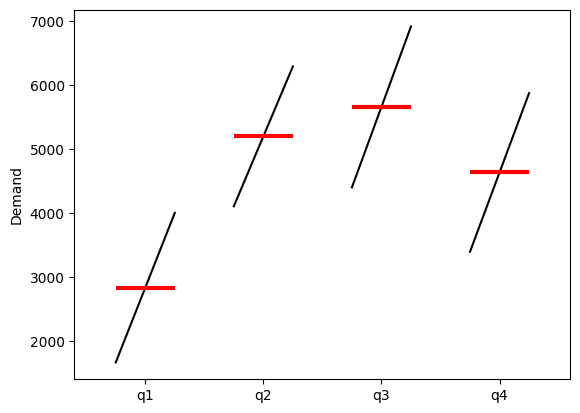

In [51]:

quarter_plot(df_temp['y'].resample('QE').mean(), ylabel='Demand'); 

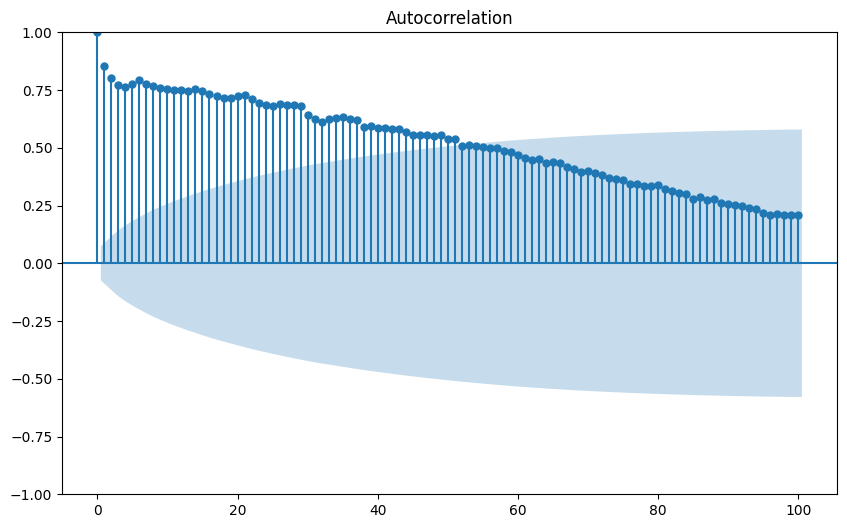

In [52]:
fig, ax = plt.subplots(figsize = (10,6)) 
plot_acf(df_temp['y'], lags=100, ax = ax); 

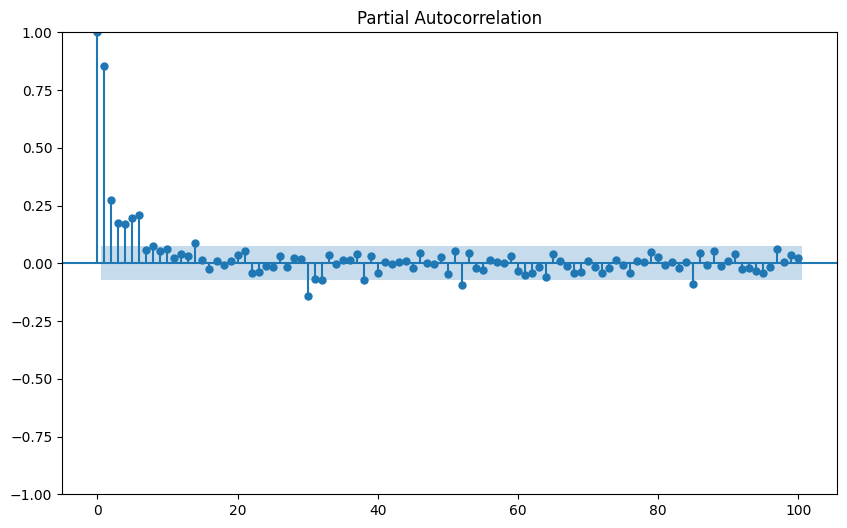

In [53]:
fig, ax = plt.subplots(figsize = (10,6)) 
plot_pacf(df_temp['y'], lags=100, ax = ax); 

In [54]:
gen_holidays = pd.DataFrame(
    {
        "holiday": "gen_holiday",
        "ds": df[df.holiday == 1]["ds"],
        "lower_window": -2,
        "upper_window": 2,
    }
)


# Christmas
xmas = pd.DataFrame(
    {
        "holiday": "christmas",
        "ds": pd.to_datetime(["2011-12-24", "2012-12-24"]),
        "lower_window": -5,
        "upper_window": 3,
    }
)
# New Year's eve
nye = pd.DataFrame(
    {
        "holiday": "new_years",
        "ds": pd.to_datetime(["2011-12-31", "2012-12-31"]),
        "lower_window": -3,
        "upper_window": 3,
    }
)
# Easter
easter = pd.DataFrame(
    {
        "holiday": "easter",
        "ds": pd.to_datetime(["2011-04-24", "2012-04-08"]),
        "lower_window": -3,
        "upper_window": 3,
    }
)


# Combine all the holidays
holidays = pd.concat([gen_holidays, xmas, nye, easter])

In [55]:
# Series.shift(n) - each value is moved to n rows(s) below its current position 

# create lagged values for the regressors temp and atemp with sepcified lags 


for lag in [1,3,5,7]: 
    df[f'temp_lag_{lag}'] = df['temp'].shift(lag)
    df[f'atemp_lag_{lag}'] = df['atemp'].shift(lag) 

In [56]:
# Correlation matrix between the lagged values and y
columns = ['y'] + [f'{var}_lag_{lag}' for var in ['temp', 'atemp'] for lag in [1,3,5,7]]
df[columns].corr()

,y,temp_lag_1,temp_lag_3,temp_lag_5,temp_lag_7,atemp_lag_1,atemp_lag_3,atemp_lag_5,atemp_lag_7
y,1.000000,0.590368,0.581922,0.589976,0.595830,0.586681,0.577076,0.587374,0.591886
temp_lag_1,0.590368,1.000000,0.892245,0.861173,0.864545,0.991526,0.882663,0.847990,0.852673
temp_lag_3,0.581922,0.892245,1.000000,0.891829,0.860613,0.877489,0.991519,0.882187,0.847451
temp_lag_5,0.589976,0.861173,0.891829,1.000000,0.891432,0.848465,0.877082,0.991490,0.881814
temp_lag_7,0.595830,0.864545,0.860613,0.891432,1.000000,0.853113,0.847940,0.876584,0.991475
atemp_lag_1,0.586681,0.991526,0.877489,0.848465,0.853113,1.000000,0.869430,0.836607,0.842372
atemp_lag_3,0.577076,0.882663,0.991519,0.877082,0.847940,0.869430,1.000000,0.868989,0.836076
atemp_lag_5,0.587374,0.847990,0.882187,0.991490,0.876584,0.836607,0.868989,1.000000,0.868539
atemp_lag_7,0.591886,0.852673,0.847451,0.881814,0.991475,0.842372,0.836076,0.868539,1.000000


In [57]:
# kick out all lagged variables but temp_lag1 

df = df.iloc[:,:-7]

In [58]:
df

,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weather_sit_2,weather_sit_3,temp_lag_1
0,2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446,985,True,False,NaN
1,2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539,801,True,False,0.344167
2,2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,False,False,0.363478
3,2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,False,False,0.196364
4,2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,False,False,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...
696,2012-11-27,0,1,2,0.291667,0.281558,0.786667,0.237562,3959,True,False,0.313333
697,2012-11-28,0,1,1,0.296667,0.289762,0.506250,0.210821,5260,False,False,0.291667
698,2012-11-29,0,1,1,0.280870,0.298422,0.555652,0.115522,5323,False,False,0.296667
699,2012-11-30,0,1,1,0.298333,0.323867,0.649583,0.058471,5668,False,False,0.280870


In [59]:
df = df.dropna()

In [60]:
df

,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weather_sit_2,weather_sit_3,temp_lag_1
1,2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539,801,True,False,0.344167
2,2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,False,False,0.363478
3,2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,False,False,0.196364
4,2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,False,False,0.200000
5,2011-01-06,0,1,1,0.204348,0.233209,0.518261,0.089565,1606,False,False,0.226957
...,...,...,...,...,...,...,...,...,...,...,...,...
696,2012-11-27,0,1,2,0.291667,0.281558,0.786667,0.237562,3959,True,False,0.313333
697,2012-11-28,0,1,1,0.296667,0.289762,0.506250,0.210821,5260,False,False,0.291667
698,2012-11-29,0,1,1,0.280870,0.298422,0.555652,0.115522,5323,False,False,0.296667
699,2012-11-30,0,1,1,0.298333,0.323867,0.649583,0.058471,5668,False,False,0.280870


In [62]:
model = Prophet(
    holidays=holidays,
    seasonality_mode="multiplicative",
    seasonality_prior_scale=10,  # Increases flexibility of seasonality
    holidays_prior_scale=10,  # increases impact of holidays
    changepoint_prior_scale=0.05,  # Control flexibility in detecting trend changes
)

# Add additional regressors (external factors) to the model
model.add_regressor("workingday")  # Whether it's a working day
model.add_regressor("temp")  # Temperature
model.add_regressor("atemp")  # Apparent temperature
model.add_regressor("hum")  # Humidity
model.add_regressor("windspeed")  # Wind speed
model.add_regressor("weather_sit_2")  # Weather situation category 2
model.add_regressor("weather_sit_3")  # Weather situation category 3
model.add_regressor("temp_lag_1")  # Temperature from previous time step

# Fit the model to the data
model.fit(df)

00:05:05 - cmdstanpy - INFO - Chain [1] start processing
00:05:06 - cmdstanpy - INFO - Chain [1] done processing


- seasonality_prior_scale
- Typical range: 0.01 to 10
- Lower values make seasonality smoother, while higher values allow more flexibility.
----------------------------------------------

- holidays_prior_scale
- Typical range: 0.01 to 10
- Higher values increase the impact of holidays on the forecast.
----------------------------------------------------

- changepoint_prior_scale
- Typical range: 0.001 to 0.5
- Lower values (e.g., 0.001 to 0.05) result in smoother trend changes.
- Higher values (e.g., 0.1 to 0.5) allow more abrupt trend shifts.


In [65]:
# Regressor Coefficients 
# Used to extract and display the coefficients of additional regressors added to prophet model 
# Positive coefficients indicates the regressor increases the target variable 
# Negative coefficient indicate the regressor decreases the target variable. 
# The magnitude of the coefficient represents the strength of the effect. 


from prophet.utilities import regressor_coefficients 
coefs = pd.DataFrame(regressor_coefficients(model)) 





def interpret_prophet_coefficients(df): 
    interpretations = [] 

    for _, row in df.iterrows(): 
        regressor = row['regressor'] 
        mode = row['regressor_mode'] 
        coef = row['coef'] 

        effect_type = 'increase' if coef > 0 else 'decrease' 

        # Generate interpretation based on regressor mode 
        if mode == "multiplicative": 
            interpretation = f"For each unit increase in {regressor}, the target variable is expected to {effect_type} by {abs(coef) * 100:.2f}%  (multiplicatively)."
        elif mode == "additive":
             interpretation = f"For each unit increase in {regressor}, the target variable changes by {coef:.2f} units (additively)."
        interpretations.append(interpretation) 
    return interpretations 





In [67]:
interpretations = interpret_prophet_coefficients(coefs)


# Print each interpretation
for interpretation in interpretations:
    print(interpretation)

For each unit increase in workingday, the target variable is expected to increase by 69.09%  (multiplicatively).
For each unit increase in temp, the target variable is expected to increase by 79.11%  (multiplicatively).
For each unit increase in atemp, the target variable is expected to increase by 111.11%  (multiplicatively).
For each unit increase in hum, the target variable is expected to decrease by 33.28%  (multiplicatively).
For each unit increase in windspeed, the target variable is expected to decrease by 53.12%  (multiplicatively).
For each unit increase in weather_sit_2, the target variable is expected to decrease by 11.68%  (multiplicatively).
For each unit increase in weather_sit_3, the target variable is expected to decrease by 55.50%  (multiplicatively).
For each unit increase in temp_lag_1, the target variable is expected to decrease by 48.93%  (multiplicatively).


## Cross-Validate 

In [69]:
from prophet.diagnostics import cross_validation 


df.shape[0] - 180 

520

In [70]:
df_cv = cross_validation(
    model=model,
    initial = '521 days', # Size of initial training period 
    horizon = '30 days', # Forecast horizin 
    parallel='processes',
    period='15 days', # Step size between cutoff dates, 

)

In [71]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-20,8570.249940,7847.453565,9289.436634,6211,2012-06-19
1,2012-06-21,8945.358592,8178.825283,9733.493176,5905,2012-06-19
2,2012-06-22,8529.033999,7789.964333,9246.905530,5823,2012-06-19
3,2012-06-23,8074.642600,7271.020217,8815.831018,7458,2012-06-19
4,2012-06-24,8232.239672,7472.987701,9035.449580,6891,2012-06-19


In [72]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-20,8570.249940,7847.453565,9289.436634,6211,2012-06-19
1,2012-06-21,8945.358592,8178.825283,9733.493176,5905,2012-06-19
2,2012-06-22,8529.033999,7789.964333,9246.905530,5823,2012-06-19
3,2012-06-23,8074.642600,7271.020217,8815.831018,7458,2012-06-19
4,2012-06-24,8232.239672,7472.987701,9035.449580,6891,2012-06-19
...,...,...,...,...,...,...
295,2012-11-27,5563.764455,4753.407899,6449.594286,3959,2012-11-01
296,2012-11-28,6992.465807,6135.655873,7818.148472,5260,2012-11-01
297,2012-11-29,7260.650173,6413.814147,8130.847687,5323,2012-11-01
298,2012-11-30,7590.861797,6719.312613,8464.518119,5668,2012-11-01


In [ ]:

from prophet.diagnostics import performance_metrics
# horizon - the number of time steps (periods) into the future for which predictions are made 

performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,2.071772e+06,1439.365026,1175.362063,0.203227,0.151392,0.183028,0.433333
1,4 days,2.202697e+06,1484.148664,1185.468185,0.200771,0.126422,0.180591,0.433333
2,5 days,1.925740e+06,1387.710369,1112.416141,0.186045,0.113663,0.167731,0.466667
3,6 days,1.266067e+06,1125.196425,929.936774,0.148314,0.113663,0.141064,0.500000
4,7 days,1.024798e+06,1012.323232,841.853613,0.128949,0.090682,0.127818,0.600000
5,8 days,8.231484e+05,907.275276,711.675162,0.102537,0.081570,0.105155,0.766667
6,9 days,7.552018e+05,869.023470,675.584346,0.096956,0.074936,0.097261,0.766667
7,10 days,1.119240e+06,1057.941360,729.071640,0.107495,0.074839,0.101884,0.733333
8,11 days,1.333394e+06,1154.726877,815.337754,0.124707,0.080637,0.115841,0.633333
9,12 days,1.818321e+06,1348.451334,987.808961,0.157130,0.118447,0.148487,0.533333


In [74]:
# RMSE and MAPE
rmse = round(performance_metrics(df_cv)['rmse'].mean(),0)
mape = round(performance_metrics(df_cv)['mape'].mean()* 100 ,2)
print(f"The RMSE is {rmse}")
print(f"The MAPE is {mape} %")

The RMSE is 1350.0
The MAPE is 18.34 %


c:\Work\MLOps\flask_env\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Work\MLOps\flask_env\Lib\site-packages\prophet\plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


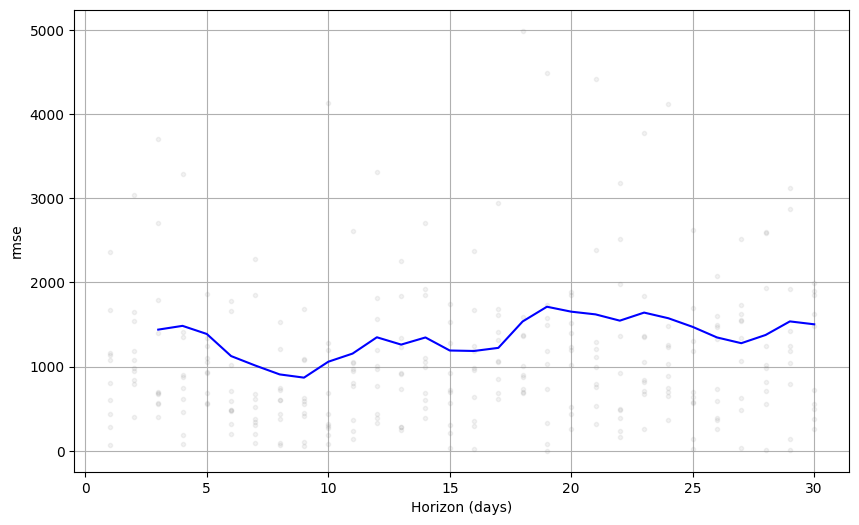

In [76]:
from prophet.plot import plot_cross_validation_metric 

plot_cross_validation_metric(df_cv, metric='rmse');

In [77]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-20,8570.249940,7847.453565,9289.436634,6211,2012-06-19
1,2012-06-21,8945.358592,8178.825283,9733.493176,5905,2012-06-19
2,2012-06-22,8529.033999,7789.964333,9246.905530,5823,2012-06-19
3,2012-06-23,8074.642600,7271.020217,8815.831018,7458,2012-06-19
4,2012-06-24,8232.239672,7472.987701,9035.449580,6891,2012-06-19
...,...,...,...,...,...,...
295,2012-11-27,5563.764455,4753.407899,6449.594286,3959,2012-11-01
296,2012-11-28,6992.465807,6135.655873,7818.148472,5260,2012-11-01
297,2012-11-29,7260.650173,6413.814147,8130.847687,5323,2012-11-01
298,2012-11-30,7590.861797,6719.312613,8464.518119,5668,2012-11-01


In [78]:
df_cv['deviation'] = df_cv['yhat'] - df_cv['y'] 

df_cv['pct_deviation'] = ((df_cv['yhat'] / df_cv['y']) -1) * 100 

In [79]:
# Days with the highest percentage deviation
df_cv.sort_values(by = 'pct_deviation', ascending = False).head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,deviation,pct_deviation
290,2012-11-22,6843.630286,5969.375055,7716.217936,2425,2012-11-01,4418.630286,182.211558
293,2012-11-25,6539.212667,5763.849484,7354.957259,2424,2012-11-01,4115.212667,169.769499
292,2012-11-24,6054.038004,5145.383764,6887.482828,2277,2012-11-01,3777.038004,165.877822
17,2012-07-07,9830.430979,9038.003213,10578.372296,4840,2012-06-19,4990.430979,103.108078
18,2012-07-08,9155.089637,8428.417217,9877.614243,4672,2012-06-19,4483.089637,95.956542
291,2012-11-23,7093.905397,6250.250255,7993.721950,3910,2012-11-01,3183.905397,81.429806
32,2012-07-07,8544.025562,7706.129162,9379.594623,4840,2012-07-04,3704.025562,76.529454
9,2012-06-29,9590.771822,8872.202416,10318.457073,5463,2012-06-19,4127.771822,75.558701
33,2012-07-08,7956.933267,7103.852926,8779.382066,4672,2012-07-04,3284.933267,70.311072
11,2012-07-01,8842.984801,8091.407823,9637.885972,5531,2012-06-19,3311.984801,59.880398


In [80]:
# Days with the highest percentage deviation
df_cv.sort_values(by = 'deviation', ascending = False).head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,deviation,pct_deviation
17,2012-07-07,9830.430979,9038.003213,10578.372296,4840,2012-06-19,4990.430979,103.108078
18,2012-07-08,9155.089637,8428.417217,9877.614243,4672,2012-06-19,4483.089637,95.956542
290,2012-11-22,6843.630286,5969.375055,7716.217936,2425,2012-11-01,4418.630286,182.211558
9,2012-06-29,9590.771822,8872.202416,10318.457073,5463,2012-06-19,4127.771822,75.558701
293,2012-11-25,6539.212667,5763.849484,7354.957259,2424,2012-11-01,4115.212667,169.769499
292,2012-11-24,6054.038004,5145.383764,6887.482828,2277,2012-11-01,3777.038004,165.877822
32,2012-07-07,8544.025562,7706.129162,9379.594623,4840,2012-07-04,3704.025562,76.529454
11,2012-07-01,8842.984801,8091.407823,9637.885972,5531,2012-06-19,3311.984801,59.880398
33,2012-07-08,7956.933267,7103.852926,8779.382066,4672,2012-07-04,3284.933267,70.311072
291,2012-11-23,7093.905397,6250.250255,7993.721950,3910,2012-11-01,3183.905397,81.429806


In [81]:
# Define the parameter grid to search
param_grid = {
    "changepoint_prior_scale": [0.05, 0.5],
    "seasonality_prior_scale": [10, 20],
    "holidays_prior_scale": [10, 20],
    "seasonality_mode": ["additive", "multiplicative"],
}


all_params = list(ParameterGrid(param_grid))

In [82]:
tuning_results = [] 

for param in all_params: 

    model = Prophet(
        holidays=holidays,
        **param
    )

    model.add_regressor("workingday")
    model.add_regressor("temp")
    model.add_regressor("atemp")
    model.add_regressor("hum")
    model.add_regressor("windspeed")
    model.add_regressor("weather_sit_2")
    model.add_regressor("weather_sit_3")
    model.add_regressor("temp_lag_1")

    model.fit(df) 

    df_cv = cross_validation(
        model=model, 
        period='15 days', 
        initial="521 days", 
        horizon="30 days", 
        parallel='processes'
    )

    rmse = performance_metrics(df_cv)['rmse'].mean() 

    tuning_results.append(rmse)



00:51:23 - cmdstanpy - INFO - Chain [1] start processing
00:51:23 - cmdstanpy - INFO - Chain [1] done processing
00:51:26 - cmdstanpy - INFO - Chain [1] start processing
00:51:26 - cmdstanpy - INFO - Chain [1] done processing
00:51:30 - cmdstanpy - INFO - Chain [1] start processing
00:51:30 - cmdstanpy - INFO - Chain [1] done processing
00:51:33 - cmdstanpy - INFO - Chain [1] start processing
00:51:33 - cmdstanpy - INFO - Chain [1] done processing
00:51:37 - cmdstanpy - INFO - Chain [1] start processing
00:51:37 - cmdstanpy - INFO - Chain [1] done processing
00:51:40 - cmdstanpy - INFO - Chain [1] start processing
00:51:40 - cmdstanpy - INFO - Chain [1] done processing
00:51:43 - cmdstanpy - INFO - Chain [1] start processing
00:51:43 - cmdstanpy - INFO - Chain [1] done processing
00:51:46 - cmdstanpy - INFO - Chain [1] start processing
00:51:46 - cmdstanpy - INFO - Chain [1] done processing
00:51:49 - cmdstanpy - INFO - Chain [1] start processing
00:51:50 - cmdstanpy - INFO - Chain [1]

In [83]:
# Parameter tuning outcome 

outcome = pd.DataFrame(all_params) 

outcome['tuning_results'] = tuning_results 

In [84]:
outcome

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,tuning_results
0,0.05,10,additive,10,1103.691694
1,0.05,10,additive,20,1103.500161
2,0.05,10,multiplicative,10,1349.577214
3,0.05,10,multiplicative,20,1357.687452
4,0.05,20,additive,10,1103.709236
5,0.05,20,additive,20,1104.075375
6,0.05,20,multiplicative,10,1365.347077
7,0.05,20,multiplicative,20,1340.791724
8,0.50,10,additive,10,1179.592238
9,0.50,10,additive,20,1181.236872


In [85]:
# Fetch the best params
best_params = all_params[tuning_results.index(min(tuning_results))]

## Predict the future 

In [87]:
df_train = pd.read_csv(r"C:\Users\siddharth\Desktop\Python-Time-Series-Forecasting\Python - Time Series Forecasting\Modern Time Series Forecasting Techniques\Prophet\Daily Bike Sharing training.csv")

df_future = pd.read_csv(r"C:\Users\siddharth\Desktop\Python-Time-Series-Forecasting\Python - Time Series Forecasting\Modern Time Series Forecasting Techniques\Prophet\Daily Bike Sharing future.csv")

df = pd.concat([df_train, df_future])

df = df.reset_index(drop=True) 


# Change the time Series variable name
# target variable as 'y'
# date as 'ds'
df = df.rename(columns = {'cnt': 'y',
                          'dteday': 'ds'})

df['ds'] = pd.to_datetime(df['ds'], format = "%m/%d/%Y")


weather_sit = pd.get_dummies(df['weathersit'], drop_first = True)

# Concatenate the original DataFrame 'df' with the dummy variables 'weather_sit'
df = pd.concat([df, weather_sit], axis = 1)




# Renaming variables 2 and 3
df = df.rename(columns = {2: 'weathersit_2',
                          3: 'weathersit_3'})

# Drop Variables That Are Not Needed
df.drop(columns = ['instant', 'season', 'yr', 'mnth', 'weekday',
                   'casual', 'registered'], inplace = True)



to_replace = df.loc[df.ds == '2012-10-28'].y.values[0]
df.loc[df.ds == '2012-10-29', 'y'] = to_replace
df.loc[df.ds == '2012-10-30', 'y'] = to_replace

In [89]:
# Define holiday events
# general holiday
gen_holidays = pd.DataFrame(
    {
        "holiday": "gen_holi",
        "ds": df[df.holiday == 1].ds,
        "lower_window": -2,
        "upper_window": 2,
    }
)
# Christmas
xmas = pd.DataFrame(
    {
        "holiday": "christmas",
        "ds": pd.to_datetime(["2011-12-24", "2012-12-24"]),
        "lower_window": -5,
        "upper_window": 3,
    }
)
# New Year's Eve
nye = pd.DataFrame(
    {
        "holiday": "new_years",
        "ds": pd.to_datetime(["2011-12-31", "2012-12-31"]),
        "lower_window": -3,
        "upper_window": 3,
    }
)
# Easter
easter = pd.DataFrame(
    {
        "holiday": "easter",
        "ds": pd.to_datetime(["2011-04-24", "2012-04-08"]),
        "lower_window": -3,
        "upper_window": 3,
    }
)


holidays = pd.concat([gen_holidays, xmas, nye, easter])

In [90]:
lag = 1 

df[f'temp_lag_{lag}'] = df['temp'].shift(lag) 



In [91]:
train = df.iloc[:-30] 

train = train.dropna()

In [94]:
model = Prophet(
    holidays=holidays,
    **best_params
)


model.add_regressor("workingday")
model.add_regressor("temp")
model.add_regressor("atemp")
model.add_regressor("hum")
model.add_regressor("windspeed")
model.add_regressor("weathersit_2")
model.add_regressor("weathersit_3")
model.add_regressor("temp_lag_1")
model.fit(train)

01:01:48 - cmdstanpy - INFO - Chain [1] start processing
01:01:48 - cmdstanpy - INFO - Chain [1] done processing


## Forecasting 

In [96]:
forecast_regressors = df.drop(columns=['ds','y']).dropna() 

forecast_regressors.reset_index(drop=True, inplace=True)

In [97]:
future = model.make_future_dataframe(periods=30) 

future = pd.concat([future, forecast_regressors], axis=1)

In [98]:
forecast = model.predict(future) 

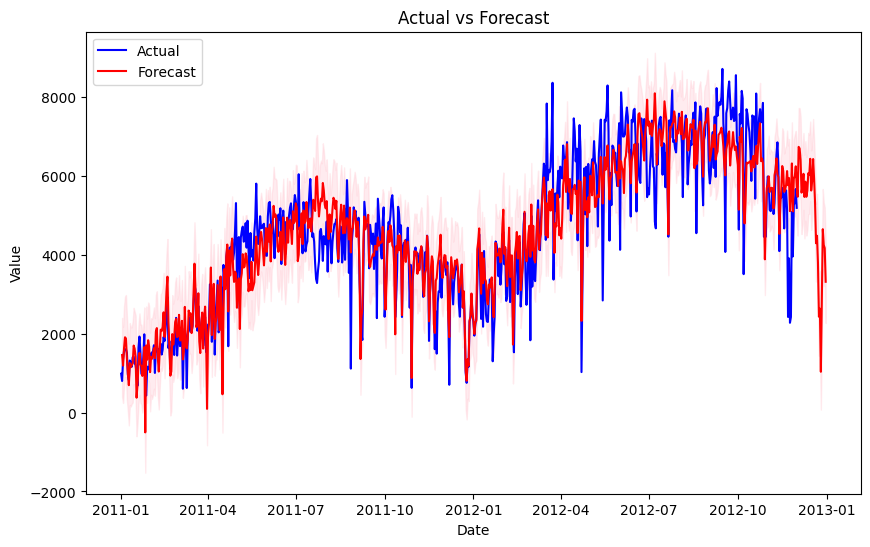

In [99]:
# Visualize time series plot
plt.figure(figsize=(10, 6))
# Plot actual and forecasted values
plt.plot(df['ds'], df['y'], label='Actual', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')
# Fill the uncertainty interval (between yhat_lower and yhat_upper) with a pink color
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
# add title, xlabel, ylabel, legend
plt.title('Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

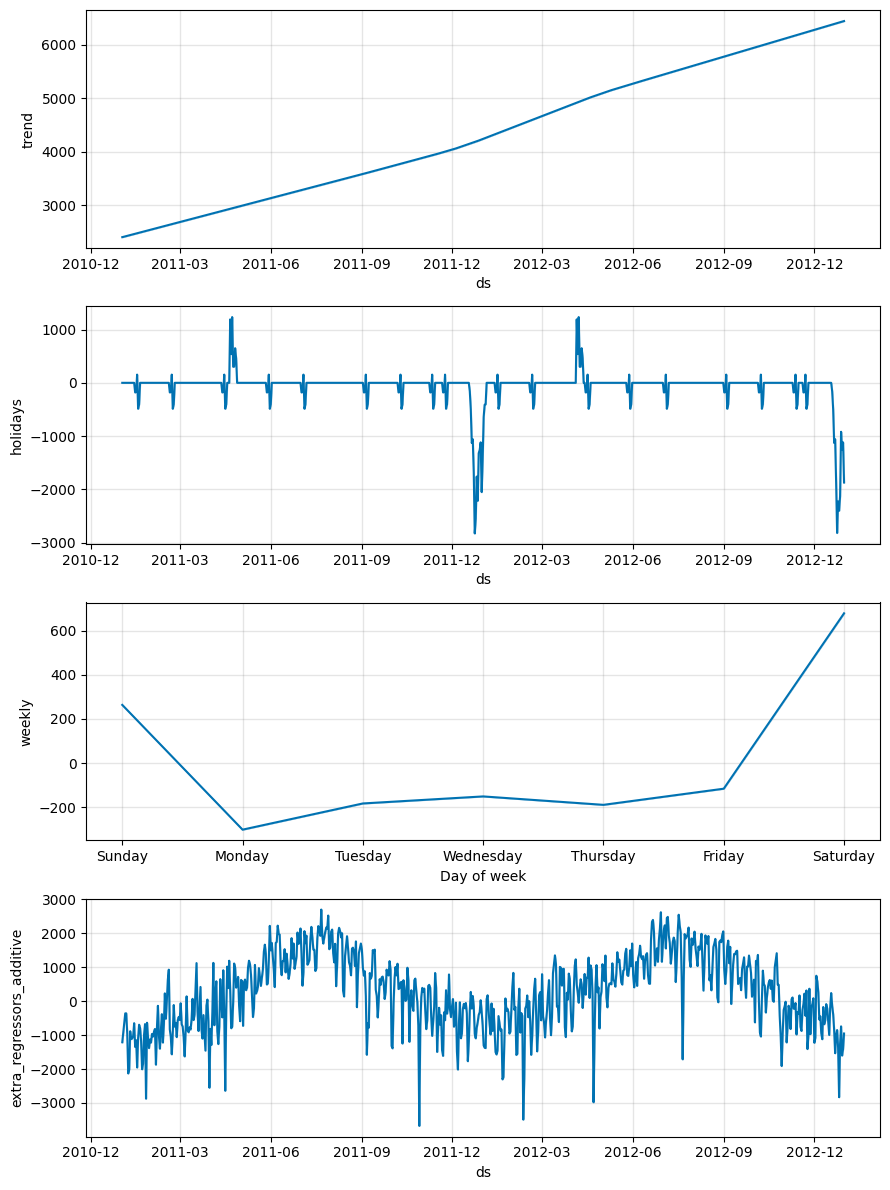

In [100]:
model.plot_components(forecast); 

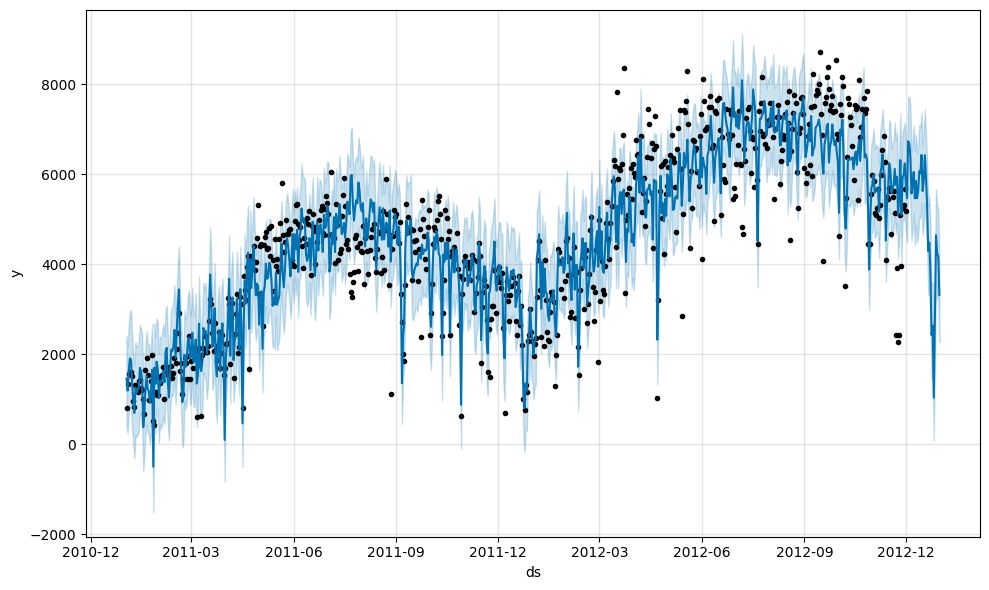

In [101]:
model.plot(forecast); 

In [102]:
from prophet.plot import plot_plotly 

fig = plot_plotly(model, forecast) 
fig 